In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

from IPython.display import clear_output

In [2]:
import fulu
import utils
from binned_split import binned_train_test_split
from copy import deepcopy

In [3]:
from joblib import Parallel, delayed

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [5]:
data = pd.read_csv('../data/plasticc/good_objects.csv.gz')

data = data[data.detected_bool == 1]

In [6]:
data.head()

,good_objects.csv,object_id,mjd,passband,flux,flux_err,detected_bool,log_lam,class
0,924.0,730.0,60532.3019,2.0,20.994711,1.047298,1.0,3.790512,0.0
1,926.0,730.0,60532.3173,3.0,31.523088,1.569497,1.0,3.875155,0.0
2,927.0,730.0,60532.3282,4.0,41.159981,2.310168,1.0,3.938479,0.0
3,928.0,730.0,60532.3392,5.0,46.795868,5.458707,1.0,3.987288,0.0
4,931.0,730.0,60535.2957,3.0,30.361010,2.107024,1.0,3.875155,0.0


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Utils

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [305]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 7 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 7:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

# Visualization

In [13]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

In [14]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 4))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=2., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Time', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

13.0


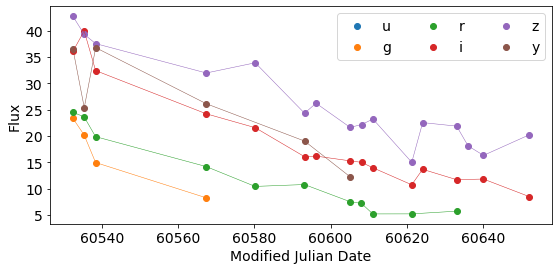

34.0


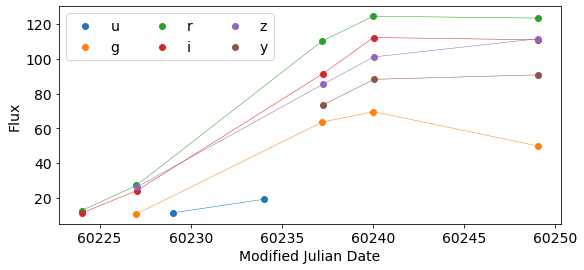

35.0


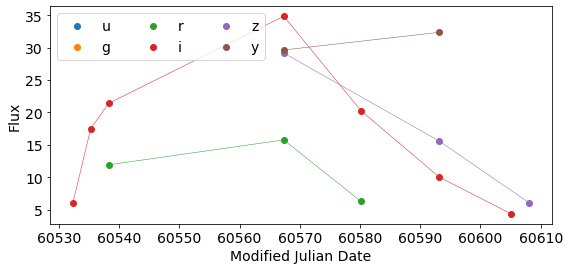

69.0


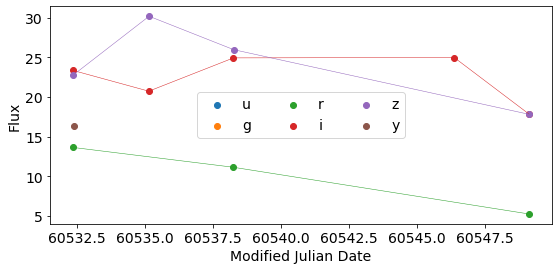

88.0


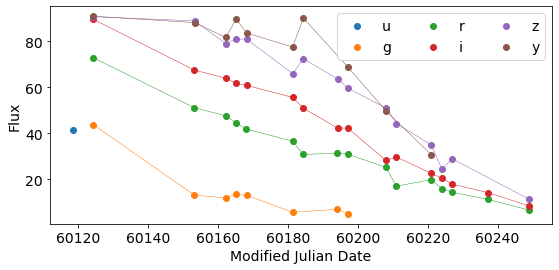

In [15]:
for i in object_ids[:5]:
    anobject = get_object(data, i)
    print(i)
    plot_light_curves(anobject)
    plt.show()

# One object test Test

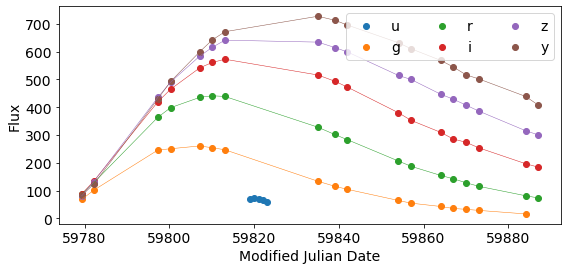

In [16]:
anobject = get_object(data, 34299) # 34299, 329277
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
# plt.savefig('light_curve_34299.pdf', format='pdf')

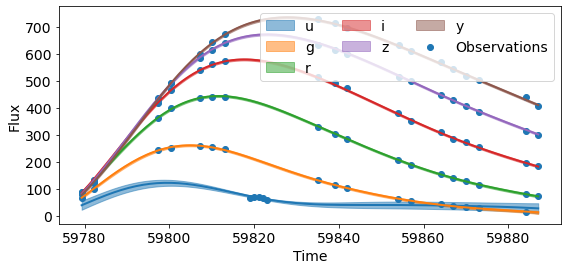

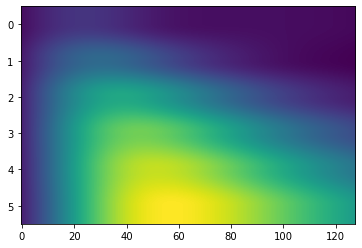

In [17]:
# train test split
t = anobject['mjd'].values
flux = anobject['flux'].values
flux_err = anobject['flux_err'].values
passband = anobject['passband'].values

# approximation model
aug = fulu.GaussianProcessesAugmentation(passband2lam)
aug.fit(t, flux, flux_err, passband)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=128)

# convert values to 2D-array
data_array = flux_aug.reshape((6, 128)).T

# add target value for this curve
true_class = int(anobject['class'].to_numpy()[0])


# plotting
plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t, flux, label='Observations')
plt.legend(loc='best', ncol=3, fontsize=14)
plt.show()

plt.imshow(data_array.T, aspect='auto')
plt.show()

# Image preparation

In [18]:
N_obs = 128

In [19]:
def get_images(outputs, silent=False):
    images = []
    labels = []
    for img in outputs:
        if img is not None:
            labels.append(img[0])
            images.append(img[1])
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [20]:
def one_object_run(i):
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    # take only good curves
    if not is_good(anobject): 
        return None
    
    # train test split
    t = anobject['mjd'].values
    flux = anobject['flux'].values
    flux_err = anobject['flux_err'].values
    passband = anobject['passband'].values
    
    # approximation model
    if MODEL == "GP":
        aug = fulu.GaussianProcessesAugmentation(passband2lam)
    elif MODEL == "NN_sklearn":
        aug = fulu.MLPRegressionAugmentation(**params)
    elif MODEL == "NN_pytorch":
        aug = fulu.SingleLayerNetAugmentation(**params)
    elif MODEL == "BNN":
        aug = fulu.BayesianNetAugmentation(**params)
    elif MODEL == "NF":
        aug = fulu.NormalizingFlowAugmentation(**params)

    # fit the model
    aug.fit(t, flux, flux_err, passband)

    # augmentation
    t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=N_obs)

    # convert values to 2D-array
    image = flux_aug.reshape((6, N_obs)).T

    # add target value for this curve
    true_class = int(anobject['class'].to_numpy()[0])
    
    return (true_class, [image])

# Classifier preparation

In [288]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

device = 'cpu'

# model for binary classificiation: Supernova Ia VS others
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn = nn.Sequential(nn.Conv2d(1, 4, kernel_size=(5, 3)),
                                 #nn.BatchNorm2d(4),
                                 nn.ReLU(),
                                 nn.MaxPool2d((2, 1), (2, 1)),
                                 nn.Dropout(0.2),
                                 nn.Conv2d(4, 16, kernel_size=(5, 3)),
                                 #nn.BatchNorm2d(16), 
                                 nn.ReLU(),
                                 nn.MaxPool2d((2, 1), (2, 1)),
                                 nn.Dropout(0.2), 
                                 nn.Flatten(), 
                                 nn.Linear(232*4, 64), 
                                 #nn.BatchNorm1d(64), 
                                 nn.ReLU(), 
                                 nn.Dropout(0.2), 
                                 nn.Linear(64, 1), 
                                 nn.Sigmoid())

    def forward(self, x):
        x = self.cnn(x)
        return x

In [269]:
Net()

Net(
  (cnn): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 16, kernel_size=(5, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten()
    (9): Linear(in_features=928, out_features=64, bias=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [303]:
def light_curve_classification(images, labels):
    

    # train / test split data
    X_train, X_test, y_train, y_test = train_test_split(images, 
                                                        labels,
                                                        test_size=0.4,
                                                        random_state=42, 
                                                        stratify=labels)

    # normalize input data
    X_train_norm = np.array((X_train - X_train.mean()) / X_train.std(), dtype=np.float32)
    X_test_norm = np.array((X_test - X_train.mean()) / X_train.std(), dtype=np.float32)

    # convert train data to tensors
    X_train_tensor = torch.from_numpy(X_train_norm)
    y_train_tensor = torch.from_numpy(np.array(y_train, dtype=np.float32))

    batch = 256
    # create train data loader
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch,
                                              shuffle=True, drop_last=False)
    
#     for i in trainloader:
#         inputs, labels_batch = i
#         print(inputs.size())

    # convert test data to tensors
    X_test_tensor = torch.from_numpy(X_test_norm)
    y_test_tensor = torch.from_numpy(np.array(y_test, dtype=np.float32))


    # initialize binary classifier
    net = Net()
    criterion = nn.BCELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.1)

    epochs = np.arange(1000)

    best_loss = float('inf')
    best_state = None
    loss_history = []
    test_history = []

    for epoch in tqdm(epochs):  # loop over the dataset multiple times
        epoch_loss = 0.0
        net = net.train()
        for info in trainloader:
            # get the inputs; info is a list of [inputs, labels]
            inputs, labels_batch = info
            outputs = net(inputs)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
        # print mean loss for the epoch
        cur_loss = epoch_loss / X_train_norm.shape[0]
        loss_history.append(cur_loss)

        net = net.eval()
        y_test_tensor_pred = net(X_test_tensor)
        test_loss = criterion(y_test_tensor_pred, y_test_tensor).item()
        test_loss /= X_test_norm.shape[0]
        test_history.append(test_loss)
        
        if test_loss <= best_loss:
            best_loss = test_loss
            best_state = deepcopy(net.state_dict())

        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            fig = plt.figure(figsize=(12, 6))
            plt.title("Model Loss Depending on Epoch Number", fontsize=20)
            plt.plot(loss_history, label="train loss")
            plt.plot(test_history, label="test loss")
            plt.legend(loc="best", shadow=0.1, fontsize=16)
            plt.xlabel("Epoch Number", fontsize=16)
            plt.ylabel("BCE Loss", fontsize=16)
            plt.grid(True)
            plt.show()

    #net.load_state_dict(best_state)
    y_test_pred = net(X_test_tensor).detach().numpy()[:, 0]

    
    return X_test, y_test, y_test_pred

In [34]:
from  sklearn.metrics import accuracy_score, roc_auc_score, log_loss, precision_recall_curve, auc, recall_score, precision_score
from sklearn.utils import resample

def gen_report(y_test, y_test_pred, n_iters=1000, decimals=3):
    
    metrics = []
    inds = np.arange(len(y_test))
    for i in range(n_iters):
        inds_boot = resample(inds)
        roc_auc = roc_auc_score(y_test[inds_boot], y_test_pred[inds_boot])
        logloss = log_loss(y_test[inds_boot], y_test_pred[inds_boot], eps=10**-6)
        accuracy = accuracy_score(y_test[inds_boot], 1 * (y_test_pred[inds_boot] > 0.5))
        precision, recall, _ = precision_recall_curve(y_test[inds_boot], y_test_pred[inds_boot])
        pr_auc = auc(recall, precision)
        recall = recall_score(y_test[inds_boot], 1 * (y_test_pred[inds_boot] > 0.5))
        precision = precision_score(y_test[inds_boot], 1 * (y_test_pred[inds_boot] > 0.5))
        metrics.append([roc_auc, pr_auc, logloss, accuracy, recall, precision])
    metrics = np.array(metrics)
    report = pd.DataFrame(columns=["ROC_AUC", 'PR-AUC', 'LogLoss', 'Accuracy', 'Recall', 'Precision'], 
                          data=[metrics.mean(axis=0), metrics.std(axis=0)], 
                          index=['mean', 'std'])
    return report

# Run

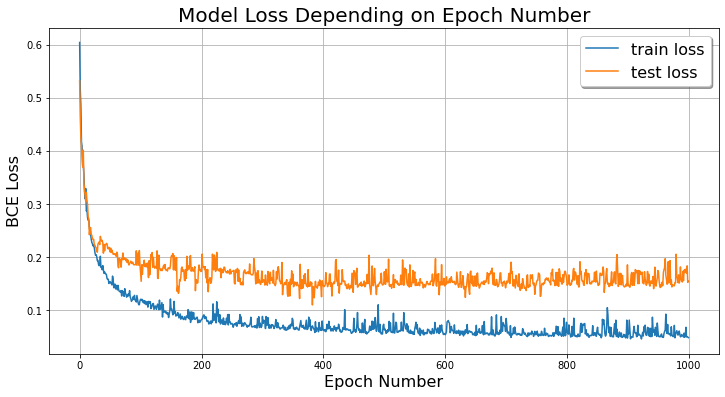


CPU times: user 1h 11min 19s, sys: 4min 2s, total: 1h 15min 21s
Wall time: 11min 22s


,ROC_AUC,PR-AUC,LogLoss,Accuracy,Recall,Precision
mean,0.991433,0.984319,0.108467,0.968839,0.952544,0.955056
std,0.001502,0.003028,0.011131,0.002673,0.005551,0.005499


In [306]:
%%time

MODEL = "GP"
outputs = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
images_gp, labels_gp = get_images(outputs)
X_test, y_test, y_test_pred_gp = light_curve_classification(images_gp, labels_gp)
gen_report(y_test, y_test_pred_gp)

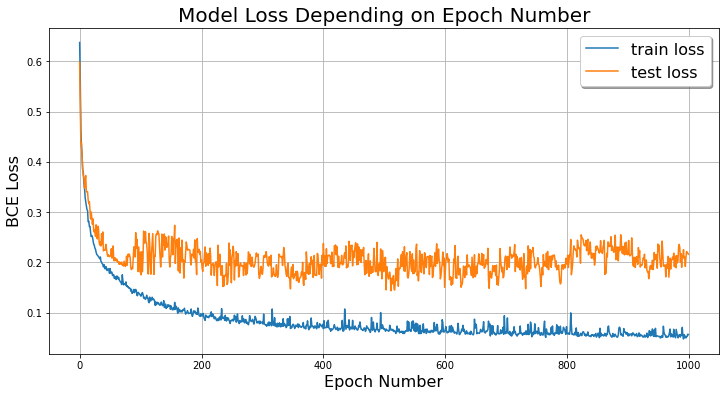


CPU times: user 1h 44min 30s, sys: 4min 24s, total: 1h 48min 54s
Wall time: 12min 42s


,ROC_AUC,PR-AUC,LogLoss,Accuracy,Recall,Precision
mean,0.989526,0.980697,0.120368,0.968856,0.950652,0.956904
std,0.001795,0.003784,0.012973,0.002642,0.005667,0.005302


In [307]:
%%time

MODEL = "NN_sklearn"
params = {'passband2lam': passband2lam, 
          'hidden_layer_sizes': (20, 20),
          'solver': 'lbfgs',
          'activation': 'tanh',
          'learning_rate_init': 0.01,
          'max_iter': 90,
          'batch_size': 1}

outputs = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
images_sk, labels_sk = get_images(outputs)
X_test, y_test, y_test_pred_sk = light_curve_classification(images_sk, labels_sk)
gen_report(y_test, y_test_pred_sk)

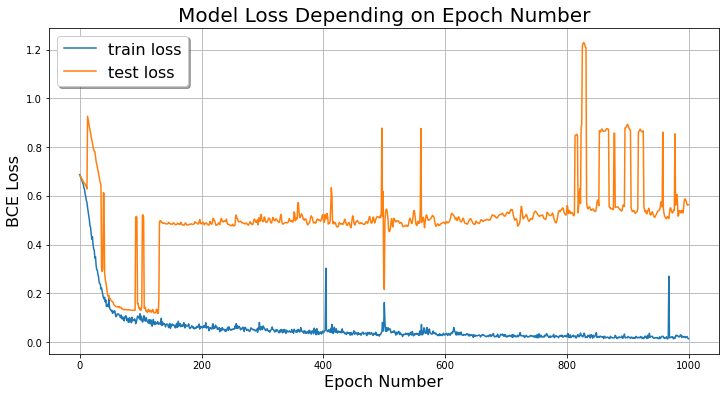

,ROC_AUC,PR-AUC,LogLoss,Accuracy,Recall,Precision
mean,0.985020,0.970227,0.242544,0.936343,0.901384,0.945373
std,0.006627,0.017473,0.070313,0.014421,0.027897,0.021795


In [304]:
X_test, y_test, y_test_pred_gp = light_curve_classification(images_gp, labels_gp)
gen_report(y_test, y_test_pred_gp)

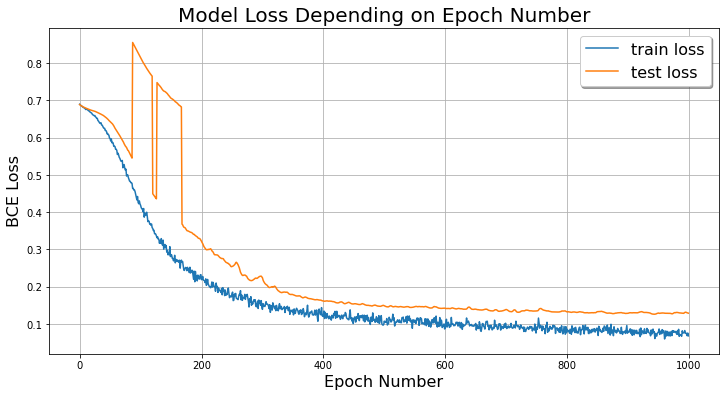

,ROC_AUC,PR-AUC,LogLoss,Accuracy,Recall,Precision
mean,0.989375,0.981968,0.129672,0.958578,0.956031,0.946354
std,0.005206,0.010353,0.030237,0.012056,0.019085,0.020823


In [302]:
X_test, y_test, y_test_pred_sk = light_curve_classification(images_sk, labels_sk)
gen_report(y_test, y_test_pred_sk)

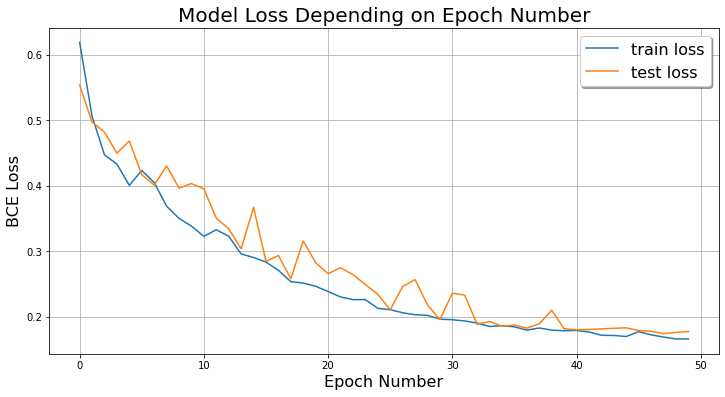


CPU times: user 6min 4s, sys: 1min 26s, total: 7min 31s
Wall time: 4min 37s


,ROC_AUC,PR-AUC,LogLoss,Accuracy
mean,0.983597,0.965243,0.165085,0.944733
std,0.001801,0.004833,0.009929,0.003353


In [27]:
%%time

MODEL = "NN_pytorch"
params = {'passband2lam': passband2lam, 
          'n_hidden': 20, 
          'activation': 'tanh', 
          'n_epochs': 100, 
          'batch_size': 500, 
          'lr': 0.1, 
          'optimizer': 'Adam', 
          'device': 'auto'}

outputs = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
images_pt, labels_pt = get_images(outputs)
X_test, y_test, y_test_pred_pt = light_curve_classification(images_pt, labels_pt)
gen_report(y_test, y_test_pred_pt)

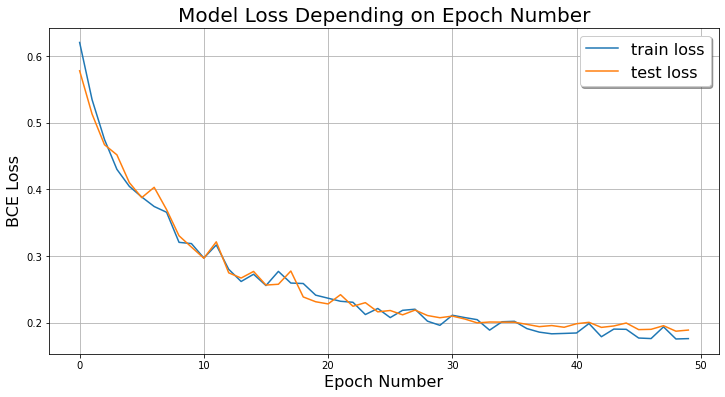


CPU times: user 9min 37s, sys: 1min 41s, total: 11min 19s
Wall time: 26min 11s


,ROC_AUC,PR-AUC,LogLoss,Accuracy
mean,0.979543,0.960250,0.176771,0.939964
std,0.002084,0.004662,0.008979,0.003538


In [28]:
%%time

MODEL = "BNN"
params = {'passband2lam': passband2lam, 
          'n_hidden': 20, 
          'prior_sigma': 0.1, 
          'n_epochs': 1000, 
          'lr': 0.01, 
          'kl_weight': 0.0001, 
          'optimizer': 'Adam', 
          'device': 'cpu'}

outputs = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
images_bn, labels_bn = get_images(outputs)
X_test, y_test, y_test_pred_bn = light_curve_classification(images_bn, labels_bn)
gen_report(y_test, y_test_pred_bn)

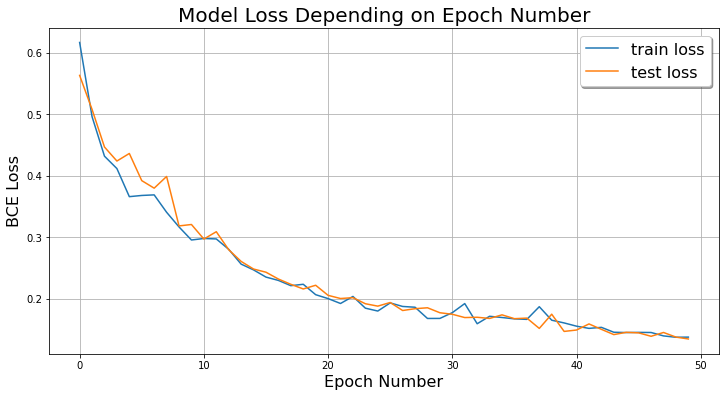


CPU times: user 14min 36s, sys: 1min 36s, total: 16min 12s
Wall time: 1h 48min 14s


,ROC_AUC,PR-AUC,LogLoss,Accuracy
mean,0.988417,0.980119,0.128586,0.954406
std,0.001475,0.002643,0.007694,0.003149


In [29]:
%%time

MODEL = "NF"
params = {'passband2lam': passband2lam, 
          'batch_size': 500, 
          'n_epochs': 1000, 
          'lr': 0.01, 
          'device': 'cpu'}

outputs = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
images_nf, labels_nf = get_images(outputs)
X_test, y_test, y_test_pred_nf = light_curve_classification(images_nf, labels_nf)
gen_report(y_test, y_test_pred_nf)

In [30]:
len(object_ids)

199434